### Classificatore
Il classificatore è un modello semplice con pochi layer densi e un layer finale per la classificazione con la softmax.\
Essendo i dati molto più piccoli le batch possono essere alte e si possono avere molte più epoche per far imparare.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models, callbacks
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, f1_score

dataset_path = '../datasets/covid_cxr_cache.npy'
model_save_path = '../models/classifier.keras'
autoencoder_path = '../models/autoencoder.keras'

epochs = 50
batch = 1024

Il dataset viene caricato e modificato in modo da avere in input solo le rappresentazioni latenti delle immagini.\
Di seguito viene caricato l'autoencoder e preso l'encoder in modo da poter creare o caricare il vettore dello spazio latente per ogni immagine.

In [2]:
dataset = np.load(dataset_path, allow_pickle=True).item()

(x_train, y_train) = dataset['train']
(x_val, y_val) = dataset['val']
(x_test, y_test) = dataset['test']

autoencoder = models.load_model(autoencoder_path)
encoder = autoencoder.get_layer('encoder')
latent_space = encoder.output_shape[1]

def data_generator(x, batch_size):
    indices = np.arange(len(x))
    while True:
        np.random.shuffle(indices)
        for i in range(0, len(x), batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_data = x[batch_indices].astype('float32') / 255.0
            yield batch_data, batch_data

batch_pred = 32
x_train = encoder.predict(data_generator(x_train, batch_pred), steps=len(x_train) // batch_pred + 1)
x_val = encoder.predict(data_generator(x_val, batch_pred), steps=len(x_val) // batch_pred + 1)
x_test = encoder.predict(data_generator(x_test, batch_pred), steps=len(x_test) // batch_pred + 1)

2121/2121 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


Purtroppo essendo il dataset molto sbilanciato verso una classe l'addestramento viene influenzato negativamente se non si fanno delle correzioni.

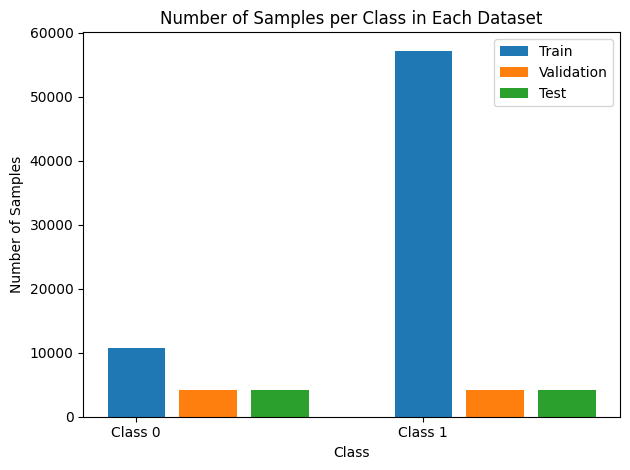

In [3]:
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

total_classes = len(train_counts)
class_weights = {i: len(y_train) / (total_classes * count) for i, count in enumerate(train_counts)}

plt.figure()
x_labels = range(total_classes)
plt.bar(x_labels, train_counts, width=0.2, label='Train', align='center')
plt.bar([x + 0.25 for x in x_labels], val_counts, width=0.2, label='Validation', align='center')
plt.bar([x + 0.5 for x in x_labels], test_counts, width=0.2, label='Test', align='center')
plt.xticks(x_labels, [f"Class {i}" for i in x_labels])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class in Each Dataset')
plt.legend()
plt.tight_layout()
plt.show()

La struttura del classificatore.\
Questo modello verrà valutato tramite *sparse_categorical_crossentropy* dato che restituirà un array con le probabilità per ogni classe.

In [4]:
in_classifier = layers.Input(shape=(latent_space,), dtype='float32')
x = layers.BatchNormalization()(in_classifier)
x = layers.Dense(128, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(32, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(8, use_bias=False)(x)
x = layers.BatchNormalization()(x)
out_classifier = layers.Dense(total_classes, activation='softmax')(x)
classifier = models.Model(in_classifier, out_classifier, name='classifier')
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,938 (85.70 KB)

 Trainable params: 21,346 (83.38 KB)

 Non-trainable params: 592 (2.31 KB)

In questa porzione di codice il modello viene addestrato

In [5]:
history = classifier.fit(x_train, y_train, validation_data=(x_val, y_val),
                         epochs=epochs,
                         batch_size=batch, class_weight=class_weights,
                         callbacks=[callbacks.ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss', mode='min')])

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - accuracy: 0.4857 - loss: 0.7675 - val_accuracy: 0.5012 - val_loss: 0.7007
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5355 - loss: 0.6921 - val_accuracy: 0.4963 - val_loss: 0.6971
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5324 - loss: 0.6875 - val_accuracy: 0.5067 - val_loss: 0.6959
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5274 - loss: 0.6851 - val_accuracy: 0.5087 - val_loss: 0.6953
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5399 - loss: 0.6850 - val_accuracy: 0.5089 - val_loss: 0.6972
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5381 - loss: 0.6833 - val_accuracy: 0.5037 - val_loss: 0.6983
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5674 - loss: 0.6794 - val_accuracy: 0.5084 - val_loss: 0.6986
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5701 - loss: 0.6767 - val_accuracy: 0.4958 - val_lo

Di seguito la loss nel tempo

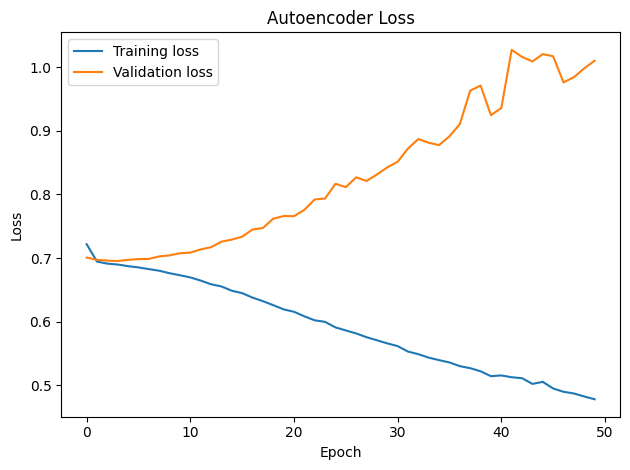

In [6]:
plt.figure(figsize=None)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title(f'Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Il risultato è che il classificatore riesce a distinguere abbastanza bene nella parte di training mentre fallisce nel generalizzare

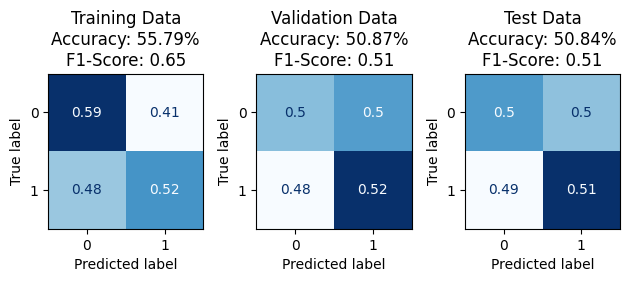

In [7]:
classifier = models.load_model(model_save_path)

y_train_pred = classifier.predict(x_train, verbose=0)
y_val_pred = classifier.predict(x_val, verbose=0)
y_test_pred = classifier.predict(x_test, verbose=0)

datasets = [
    ("Training Data", y_train, y_train_pred),
    ("Validation Data", y_val, y_val_pred),
    ("Test Data", y_test, y_test_pred)
]

_, axes = plt.subplots(1, len(datasets), figsize=None)
for i, (title, y_true, y_pred) in enumerate(datasets):
    y_pred = np.argmax(y_pred, axis=1)
    ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        normalize='true',
        display_labels=[i for i in range(total_classes)],
        cmap=plt.cm.Blues,
        colorbar=False,
        ax=axes[i]
    )
    axes[i].set_title(f"{title}\n"
                        + f"Accuracy: {balanced_accuracy_score(y_true, y_pred):.2%}\n"
                        + f"F1-Score: {f1_score(y_true, y_pred):.2f}")
plt.tight_layout()
plt.show()